In [1]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../Data/1.normalized_dataset_completed.csv")

In [3]:
import ast

array_list = df['description_token'].values
data_list = []
for item in array_list:
    data_list.append(ast.literal_eval(item))

df['description_token'] = data_list
df

,product_name,product_category_tree,description,description_token,words
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...
1,Sathiyas Cotton Bath Towel,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specification, sathiyas, cotton, bath, towel,...",specification sathiyas cotton bath towel bath...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...",oren empower extra large self adhesive sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[wallmantra, large, vinyl, sticker, sticker, p...",wallmantra large vinyl sticker sticker pack p...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[buy, uberlyfe, extra, large, pigment, polyvin...",buy uberlyfe extra large pigment polyvinyl fil...
1048,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker r ...


In [4]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

In [5]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category_tree'])) for i in range(len(df))]

catégories :  ['Home Furnishing', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Computers', 'Baby Care', 'Watches']


In [6]:
from nltk.tokenize import word_tokenize

df['words'] = df['words'].astype(str)
for i in range(len(df['words'])):
    tokenize_description = word_tokenize(df['words'][i])
    df['description_token'][i] = tokenize_description

In [7]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

2023-12-21 10:30:00.027650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [9]:
import time

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [10]:
batch_size = 10
sentences = df['words'].to_list()

In [11]:
features_USE = feature_USE_fct(sentences, batch_size)

In [12]:
from sklearn import manifold
from sklearn import cluster

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_USE)
cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100, random_state=42)

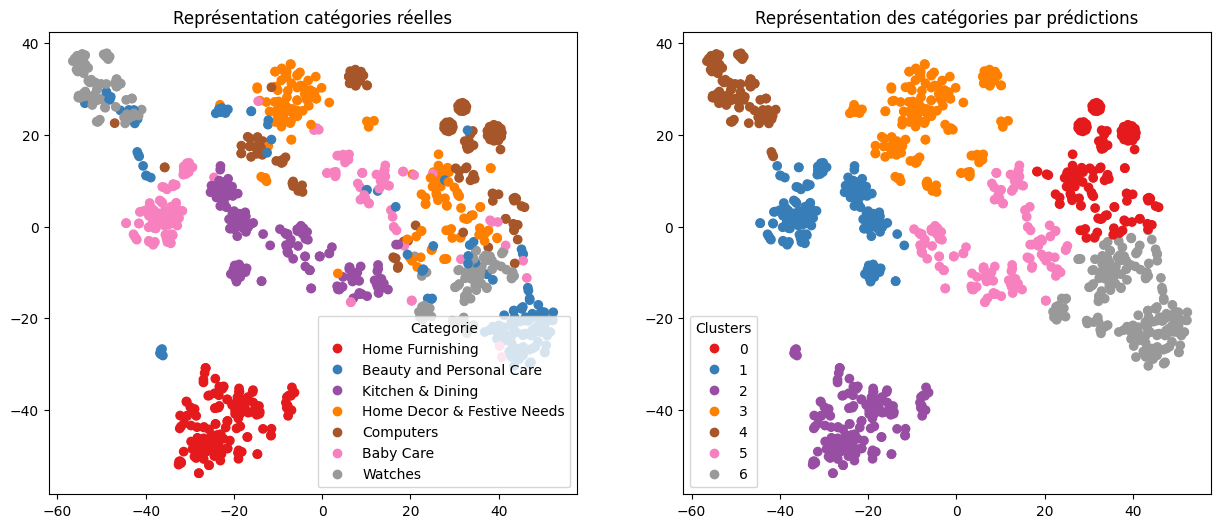

In [13]:
fig = plt.figure(figsize=(15,6))
    
ax = fig.add_subplot(121)
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
plt.title('Représentation catégories réelles')
    
ax = fig.add_subplot(122)
scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=cls.labels_, cmap='Set1')
ax.legend(handles=scatter.legend_elements()[0], labels=set(cls.labels_), loc="best", title="Clusters")
plt.title('Représentation des catégories par prédictions')
    
plt.show()

In [14]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
ARI

0.4287